**This notebook aims at producing the radial $\kappa$ profiles plot for the Kochanek rebuttal paper (Millon et al. 2019, in prep.)**

_Goal_ : show convergence maps for power-law and composite models with same logarithmic slope and Einstein radius to illustrate flexibility when using power-law and composite mass models. This is to reply CSK's argument which stipulates that H0LiCOW mass models have not enough degrees of freedom, from the observation that kinematics do not give enough constraints on $H_0$.

In [1]:
import copy
import datetime
import time
import tempfile
import corner
import os
import shutil
import scipy
import numpy as np
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Util import util
from lenstronomy.Plots import output_plots

from lens_model_sampling import LensModelLikelihood, Optimizer, Sampler
from lens_model_observables import get_theta_E_eff, get_gamma_eff, get_mean_kappa_annulus,\
    get_kappa_on_scaled_grid, get_time_delays, get_vel_disp

%matplotlib inline

In [2]:
stop_for_final_plot = True

In [3]:
likelihood_list = ['effective_einstein_radius', 'time_delays'] # or 'effective_slope'

power_law_type = 'SPEMD'  # or 'SIS'
composite_type = 'HERNQUIST'  # or 'CHAMELEON' or 'HERNQUIST'
slope_error = 1e-4
theta_E_error = 1e-4
time_delay_errors = [1e-2]
vel_disp_error = 1e0
vel_disp_bias_sign, vel_disp_bias_perc = '-', 0  # %

fix_NFW_scale_radius = True
Rs_fixed = 10  # in theta_E units

fix_second_Hernquist_scale_radius = False
second_Rs_fixed = 0.2

run_pso = True
kwargs_pso = {'n_particles': 30, 'n_iterations': 60, 'threads': 8}

run_mcmc = False
kwargs_mcmc = {'walker_ratio': 30, 'n_burn': 60, 'n_run': 60, 'threads': 8}

force_images_at_theta_E = False

# overall fixed parameters
x_source, y_source = 0.1, 0  # arbitrary, for 
z_lens, z_source = 0.5, 2    # 
light_r_eff = 0.6   # in theta_E units, typical of H0LiCOW lenses
kinem_r_apert = 1   # in theta_E units
kinem_seeing = 0.6  # arcsec

In [4]:
def plot_slice_1d(ax, xgrid_2d, map_2d, scale='lin', **kwargs):
    nx, ny = map_2d.shape
    half = int(ny/2)
    if scale == 'lin':
        ax.plot(xgrid_2d[half, :], map_2d[half, :], **kwargs)
    elif scale == 'log':
        ax.loglog(xgrid_2d[half, :], map_2d[half, :], **kwargs)
    return ax

In [5]:
# create pixel grid
num_pix = 400
delta_pix = 0.02
x_grid_1d, y_grid_1d = util.make_grid(num_pix, delta_pix)
x_grid_2d = util.array2image(x_grid_1d)
y_grid_2d = util.array2image(y_grid_1d)
print(x_grid_1d)
extent = [-num_pix/2*delta_pix, num_pix/2*delta_pix, -num_pix/2*delta_pix, num_pix/2*delta_pix]

[-3.99 -3.97 -3.95 ...  3.95  3.97  3.99]


In [6]:
### POWER-LAW MODEL ###
if power_law_type == 'SPEMD':
    ModelPowerlaw = LensModel(['SPEMD'])
    kwargs_lens_powerlaw = [{'gamma': 2, 'theta_E': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}]
elif power_law_type == 'SIS':
    ModelPowerlaw = LensModel(['SIS'])
    kwargs_lens_powerlaw = [{'theta_E': 2, 'center_x': 0, 'center_y': 0}]
    
print(ModelPowerlaw.lens_model_list, len(kwargs_lens_powerlaw))

theta_E_powerlaw = get_theta_E_eff(ModelPowerlaw, kwargs_lens_powerlaw)
print(theta_E_powerlaw)

# get convergence map for the power-law model
x_grid_2d_powerlaw, y_grid_2d_powerlaw, kappa_powerlaw \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelPowerlaw, kwargs_lens_powerlaw)

['SPEMD'] 1
1.9870472472472474


In [7]:
### COMPOSITE MODEL ###
kwargs_lens_composite = [{'Rs': 5, 'alpha_Rs': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
if composite_type == 'CHAMELEON':
    ModelComposite = LensModel(['NFW_ELLIPSE', 'CHAMELEON'])
    kwargs_lens_composite.append({'alpha_1': 1, 'w_c': 0.01, 'w_t': 30, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
elif composite_type in ['HERNQUIST', 'DOUBLE_HERNQUIST']:
    kwargs_lens_composite.append({'sigma0': 1, 'Rs': 0.8, 'center_x': 0, 'center_y': 0})
    if composite_type == 'HERNQUIST':
        ModelComposite = LensModel(['NFW_ELLIPSE', 'HERNQUIST'])
    elif composite_type == 'DOUBLE_HERNQUIST':
        ModelComposite = LensModel(['NFW_ELLIPSE', 'HERNQUIST', 'HERNQUIST'])
        kwargs_lens_composite.append({'sigma0': 5, 'Rs': 0.2, 'center_x': 0, 'center_y': 0})
        
print(ModelComposite.lens_model_list, len(kwargs_lens_composite))

# get convergence map for the whole composite model
x_grid_2d_composite, y_grid_2d_composite, kappa_composite \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite)

# get convergence map for separated (DM / baryonic matter) components
_, _, kappa_dm_only = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite, k=0)
_, _, kappa_baryon_only = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite, k=1)
if composite_type == 'DOUBLE_HERNQUIST':
    _, _, kappa_baryon_only_2 = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_composite, k=2)
    kappa_baryon_only = kappa_baryon_only + kappa_baryon_only_2


['NFW_ELLIPSE', 'HERNQUIST'] 2


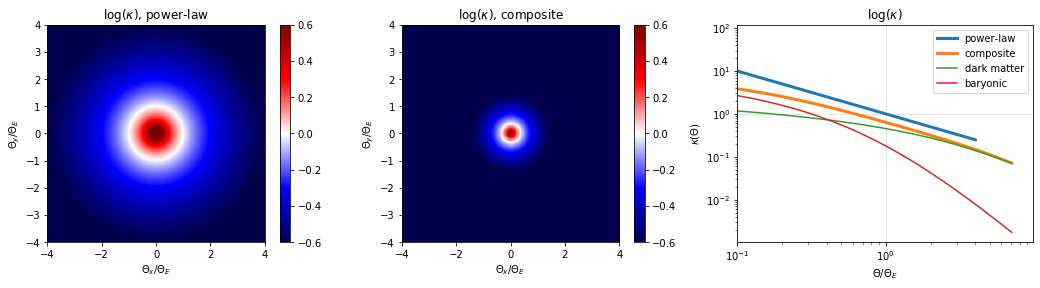

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.set_title("log($\kappa$), power-law")
im = ax.imshow(np.log10(kappa_powerlaw), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[1]
ax.set_title("log($\kappa$), composite")
im = ax.imshow(np.log10(kappa_composite), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel('$\Theta_x / \Theta_E$')
ax.set_ylabel('$\Theta_y / \Theta_E$')
plt.colorbar(im, ax=ax)

ax = axes[2]
ax.set_title("log($\kappa$)")
#r_range = np.linspace(0, num_pix/2*delta_pix, 50)
#slope_plot = kwargs_lens_powerlaw[0]['gamma'] - 1
#ax.loglog(r_range, 2*r_range**(-slope_plot), linestyle=':', color='black', label='slope $\gamma-1$')
ax.axvline(1, linewidth=1, color='black', alpha=0.1)
ax.axhline(1, linewidth=1, color='black', alpha=0.1)
plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', linewidth=3, label='power-law')
plot_slice_1d(ax, x_grid_2d_composite, kappa_composite, scale='log', linewidth=3, label='composite')
plot_slice_1d(ax, x_grid_2d_composite, kappa_dm_only, scale='log', label='dark matter')
plot_slice_1d(ax, x_grid_2d_composite, kappa_baryon_only, scale='log', label='baryonic')
if composite_type == 'DOUBLE_HERNQUIST':
    plot_slice_1d(ax, x_grid_2d_composite, kappa_baryon_only_2, scale='log', label='tmp')
ax.set_xlim(left=1e-1)
ax.set_xlabel('$\Theta / \Theta_E$')
ax.set_ylabel('$\kappa(\Theta)$')
ax.legend()

plt.show()

In [9]:
### TIME DELAYS ###
if not force_images_at_theta_E:
    time_delays_powerlaw, kwargs_ps_powerlaw = get_time_delays(ModelPowerlaw, kwargs_lens_powerlaw, z_lens, z_source, x_source, y_source, return_kwargs_ps=True)
else:
    r_ps = kwargs_lens_powerlaw[0]['theta_E'] / 2.
    kwargs_ps_powerlaw = [{'ra_image': np.array([r_ps]*2), 'dec_image': np.array([r_ps]*2)}]
    time_delays_powerlaw = get_time_delays(ModelPowerlaw, kwargs_lens_powerlaw, z_lens, z_source, kwargs_ps=kwargs_ps_powerlaw)

time_delays_composite = get_time_delays(ModelComposite, kwargs_lens_composite, z_lens, z_source, kwargs_ps=kwargs_ps_powerlaw)
print(time_delays_powerlaw)
print(time_delays_composite)

### KINEMATICS ###
vel_disp_powerlaw  = get_vel_disp(ModelPowerlaw, kwargs_lens_powerlaw, light_r_eff, kinem_r_apert, kinem_seeing, z_lens, z_source)
vel_disp_composite = get_vel_disp(ModelComposite, kwargs_lens_composite, light_r_eff, kinem_r_apert, kinem_seeing, z_lens, z_source)
print(vel_disp_powerlaw)
print(vel_disp_composite)

### <KAPPA> ###
mean_kappa_powerlaw  = get_mean_kappa_annulus(ModelPowerlaw, kwargs_lens_powerlaw, kwargs_ps_powerlaw)
mean_kappa_composite = get_mean_kappa_annulus(ModelComposite, kwargs_lens_composite, kwargs_ps_powerlaw)
print(mean_kappa_powerlaw)
print(mean_kappa_composite)

[-34.3841394]
[-19.11693236]
345.67261472458637
230.31868831523948
0.012440940808114575
0.007908573583647206


## Make the final plot for Millon et al. 2019

> Composite model 1
THETA_E : Power-law vs Composite : 1.987 vs 2.002 (0.756%)
<KAPPA> : Power-law vs Composite : 0.012 vs 0.012 (0.153%)
DELAYS : Power-law vs Composite : -34.384 vs -34.397 (0.039%)
KINEMATICS : Power-law vs Composite : 345.673 vs 313.075 (-9.430%)
> Composite model 2
THETA_E : Power-law vs Composite : 1.987 vs 2.002 (0.756%)
<KAPPA> : Power-law vs Composite : 0.012 vs 0.013 (0.653%)
DELAYS : Power-law vs Composite : -34.384 vs -34.406 (0.063%)
KINEMATICS : Power-law vs Composite : 345.673 vs 373.749 (8.122%)


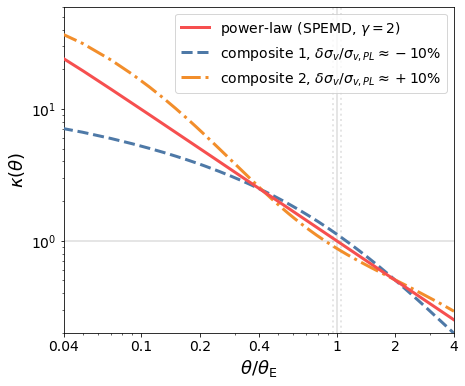

In [10]:
if stop_for_final_plot:
    # choice of final set of parameters
    kwargs_final_list = [
        [
            {'Rs': 10.0, 'alpha_Rs': 0.8027402063078675, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, 
            {'sigma0': 1.0165188890430352, 'Rs': 2.20029151621352, 'center_x': 0, 'center_y': 0}
        ],
        [
            {'Rs': 10.0, 'alpha_Rs': 2.080183457096821, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}, 
            {'sigma0': 17.01270789554873, 'Rs': 0.22833739832317357, 'center_x': 0, 'center_y': 0}
        ],
    ]
    #color_list = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']
    color_list = ['#4e79a7', '#f28e2b', '#59a14f']
    linestyle_list = ['--', '-.']
    
    rel_error_fmt = r"$\delta\sigma_{{v}}/\sigma_{{v,PL}}\approx{}{}$%"
    extra_info_list = [", {}".format(rel_error_fmt.format('-', 10)), 
                       ", {}".format(rel_error_fmt.format('+', 10))]
    # note : +/- 10 % is an approximation for clarity, and accounts for scatter in velocity dispersion calculation
    
    
    ###


    #import matplotlib as mpl
    #mpl.rc('font', family='sans-serif')

    fontsize = 14
    fontsize_small = 14
    fontsize_large = 18
    color_power_law = '#f64f4f' #'#0074bf'
    #color_composite = '#f29a1a'

    fig_final, axes = plt.subplots(1, 1, figsize=(7, 6))
    ax = axes
    
    # plot Einstein radius location
    ax.axvline(1, linewidth=2, color='black', alpha=0.1)  # Einstein radius location
    ax.axhline(1, linewidth=2, color='black', alpha=0.1)  # Einstein radius location
    
    # plot images locations
    #r_image_1 = np.sqrt(kwargs_ps_powerlaw[0]['ra_image'][0]**2 + kwargs_ps_powerlaw[0]['dec_image'][0]**2)
    #r_image_2 = np.sqrt(kwargs_ps_powerlaw[0]['ra_image'][1]**2 + kwargs_ps_powerlaw[0]['dec_image'][1]**2)
    #ax.axvline(r_image_1/theta_E_powerlaw, linewidth=2, color='black', linestyle=':', alpha=0.1)  # image position
    #ax.axvline(r_image_2/theta_E_powerlaw, linewidth=2, color='black', linestyle=':', alpha=0.1)  # image position

    # power-law
    plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', color=color_power_law, linewidth=3, zorder=10, label='power-law (SPEMD, $\gamma=2$)')

    # plot a indication for the slope
    #r_range = np.linspace(0.08, 0.2, 10)
    #ax.loglog(r_range, 3*r_range**(-slope_plot), linewidth=3, linestyle=':', color='black', label='$\gamma-1$')

    for i, kwargs_lens_final in enumerate(kwargs_final_list):
        
        print("> Composite model {}".format(i+1))

        # get time delays & velocity dispersions
        try:
            #print(tE, kwargs_lens_final)
            tE = get_theta_E_eff(ModelComposite, kwargs_lens_final)
            tE_err = (tE-theta_E_powerlaw)/theta_E_powerlaw
            mK = get_mean_kappa_annulus(ModelComposite, kwargs_lens_final, kwargs_ps_powerlaw)
            mK_err = (mK-mean_kappa_powerlaw)/mean_kappa_powerlaw
            td = get_time_delays(ModelComposite, kwargs_lens_final, z_lens, z_source, kwargs_ps=kwargs_ps_powerlaw)
            td_err = ( td - time_delays_powerlaw ) / time_delays_powerlaw
            vd = get_vel_disp(ModelComposite, kwargs_lens_final, light_r_eff, kinem_r_apert, kinem_seeing, z_lens, z_source)
            vd_err = (vd-vel_disp_powerlaw)/vel_disp_powerlaw
            print("THETA_E : Power-law vs Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(theta_E_powerlaw, tE, tE_err*100))
            print("<KAPPA> : Power-law vs Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(mean_kappa_powerlaw, mK, mK_err*100))
            print("DELAYS : Power-law vs Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(time_delays_powerlaw[-1], td[-1], td_err[-1]*100))
            print("KINEMATICS : Power-law vs Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(vel_disp_powerlaw, vd, vd_err*100))
        except Exception as e:
            # this is the case where kwargs are inconsistent with the LensModel instance for Composite
            print(e)
            continue

        # retrieve scaled kappa maps
        x_grid_2d_composite, y_grid_2d_composite, kappa_result_composite \
            = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final)
        _, _, kappa_result_dm_only \
            = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final, k=0)
        _, _, kappa_result_baryon_only \
            = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final, k=1)
        if composite_type == 'DOUBLE_HERNQUIST':
            _, _, kappa_result_baryon_only_2 \
                = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_lens_final, k=2)
            kappa_result_baryon_only = kappa_result_baryon_only + kappa_result_baryon_only_2

        # composite and separated components
        plot_slice_1d(ax, x_grid_2d_composite, kappa_result_composite, scale='log', color=color_list[i], linewidth=3, linestyle=linestyle_list[i], zorder=7, label='composite '+str(i+1) + extra_info_list[i])
        #plot_slice_1d(ax, x_grid_2d_composite, kappa_result_dm_only, scale='log', color=color_list[i], alpha=0.6, linewidth=2, linestyle='--', zorder=6, label='NFW '+str(i+1))
        #plot_slice_1d(ax, x_grid_2d_composite, kappa_result_baryon_only, scale='log', color=color_list[i], alpha=0.6, linewidth=2, linestyle='-.', zorder=5, label='Hernquist '+str(i+1))

    ax.set_xlim(4e-2, 4e0)
    ax.set_ylim(2e-1, 6e1)
    ax.set_xlabel(r"$\theta / \theta_{\rm{E}}$", fontsize=fontsize_large)
    ax.set_ylabel(r"$\kappa(\theta)$", fontsize=fontsize_large)
    ax.set_xticks([0.04, 0.1, 0.2, 0.4, 1, 2, 4])
    ax.set_xticklabels([0.04, 0.1, 0.2, 0.4, 1, 2, 4], fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    #ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize_small)
    plt.show()

    fig_final.savefig("figures/lens_models.pdf")

In [11]:
if stop_for_final_plot:
    raise RuntimeError  # stop the script

RuntimeError: 

## Initializing parameters and bounds for optimization

In [ ]:
kwargs_init = copy.deepcopy(kwargs_lens_composite)

kwargs_fixed = [{'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
if fix_NFW_scale_radius:
    kwargs_fixed[0]['Rs'] = Rs_fixed / kwargs_lens_powerlaw[0]['theta_E'] * 2
    
if composite_type == 'CHAMELEON':
    kwargs_fixed.append({'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
elif composite_type in ['HERNQUIST', 'DOUBLE_HERNQUIST']:
    kwargs_fixed.append({'center_x': 0, 'center_y': 0})
    if composite_type == 'DOUBLE_HERNQUIST':
        if fix_second_Hernquist_scale_radius:
            second_Rs_fixed = second_Rs_fixed / kwargs_lens_powerlaw[0]['theta_E'] * 2
            kwargs_fixed.append({'Rs': second_Rs_fixed, 'center_x': 0, 'center_y': 0})
        else:
            kwargs_fixed.append({'center_x': 0, 'center_y': 0})

kwargs_sigma = [{'Rs': 0.1, 'alpha_Rs': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.01, 'center_y': 0.01}]
if composite_type == 'CHAMELEON':
    kwargs_sigma.append({'alpha_1': 0.1, 'w_c': 0.1, 'w_t': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.01, 'center_y': 0.01})
elif composite_type in ['HERNQUIST', 'DOUBLE_HERNQUIST']:
    kwargs_sigma.append({'sigma0': 0.1, 'Rs': 0.1, 'center_x': 0.01, 'center_y': 0.01})
    if composite_type == 'DOUBLE_HERNQUIST':
        kwargs_sigma.append({'sigma0': 0.1, 'Rs': 0.1, 'center_x': 0.01, 'center_y': 0.01})
        
kwargs_lower = [{'Rs': 0, 'alpha_Rs': 0, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.1, 'center_y': -0.1}]
if composite_type == 'CHAMELEON':
    kwargs_lower.append({'alpha_1': 0, 'w_c': 0, 'w_t': 0, 'e1': -0.5, 'e2': -0.5, 'center_x': -0.1, 'center_y': -0.1})
elif composite_type in ['HERNQUIST', 'DOUBLE_HERNQUIST']:
    kwargs_lower.append({'sigma0': 0, 'Rs': 0, 'center_x': -0.1, 'center_y': -0.1})
    if composite_type == 'DOUBLE_HERNQUIST':
        kwargs_lower.append({'sigma0': 0, 'Rs': 0, 'center_x': -0.1, 'center_y': -0.1})
    
kwargs_upper = [{'Rs': 60, 'alpha_Rs': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 'center_y': 0.1}]
if composite_type == 'CHAMELEON':
    kwargs_upper.append({'alpha_1': 10, 'w_c': 20, 'w_t': 20, 'e1': 0.5, 'e2': 0.5, 'center_x': 0.1, 'center_y': 0.1})
elif composite_type in ['HERNQUIST', 'DOUBLE_HERNQUIST']:
    kwargs_upper.append({'sigma0': 20, 'Rs': 20, 'center_x': 0.1, 'center_y': 0.1})
    if composite_type == 'DOUBLE_HERNQUIST':
        kwargs_upper.append({'sigma0': 20, 'Rs': 20, 'center_x': 0.1, 'center_y': 0.1})


# here are defined the constraining data points (errors defined at the top of the notebook)
slope_value = kwargs_lens_powerlaw[0]['gamma']
theta_E_value = kwargs_lens_powerlaw[0]['theta_E']
time_delay_values = time_delays_powerlaw  # we fit the exact time delays
if vel_disp_bias_sign == '-':
    vel_disp_value = vel_disp_powerlaw * (1 - vel_disp_bias_perc/100.)  # we fit biased kinematics towards lower values
elif vel_disp_bias_sign == '+':
    vel_disp_value = vel_disp_powerlaw * (1 + vel_disp_bias_perc/100.)  # we fit biased kinematics towards higher values

print("Target biased velocity dispersion :", vel_disp_value)
    
likelihood_class = LensModelLikelihood(likelihood_list, ModelComposite,
                                       theta_E_value=theta_E_value, theta_E_error=theta_E_error, 
                                       slope_value=slope_value, slope_error=slope_error, 
                                       time_delay_values=time_delay_values, time_delay_errors=time_delay_errors,
                                       vel_disp_value=vel_disp_value, vel_disp_error=vel_disp_error,
                                       kwargs_lens_init=kwargs_init, kwargs_fixed_lens=kwargs_fixed, 
                                       kwargs_lower_lens=kwargs_lower, kwargs_upper_lens=kwargs_upper,
                                       kwargs_sigma_lens=kwargs_sigma, z_lens=z_lens, z_source=z_source, 
                                       kwargs_ps=kwargs_ps_powerlaw, check_bounds=True, verbose=False)
#print(likelihood_class.kwargs2args(kwargs_lens_nfw_cham))
#print(likelihood_class.args2kwargs(likelihood_class.kwargs2args(kwargs_lens_nfw_cham)))

print(kwargs_init)
print("theta_E_eff =", likelihood_class.effective_einstein_radius(kwargs_init))
print("gamma_eff =", likelihood_class.effective_slope(kwargs_init))

### Run PSO and plot results

In [ ]:
optimizer_class = Optimizer(likelihood_class)
if run_pso:
    chain_list = []
    kwargs_result, chain, param_names = optimizer_class.pso(**kwargs_pso)
    chain_list.append(['PSO', chain, param_names])
else:
    kwargs_result, logL, cost = optimizer_class.least_squares()
    print("LS : logL = {}, cost = {}".format(logL, cost))

In [ ]:
print(kwargs_result)
print("Resulting effective slope :", get_gamma_eff(ModelComposite, kwargs_result['kwargs_lens']))
print("Resulting effective Einstein radius :", get_theta_E_eff(ModelComposite, kwargs_result['kwargs_lens']))
if run_pso:
    output_plots.plot_chain_list(chain_list, index=-1)
    plt.show()

### Write in a file optimized parameters

In [ ]:
result_file = "composite_optimized.txt"
if not os.path.exists(result_file):
    open_type = 'w'
else:
    open_type = 'a'
with open(result_file, open_type) as f:
    f.write("="*20+'\n')
    f.write("day-hour : {}\n".format(datetime.datetime.now().strftime('%y%m%d-%H%M%S')))
    f.write("kappa_scaling : {}\n".format(kwargs_pso))
    f.write("kwargs_pso : {}\n".format(kwargs_pso))
    f.write("kwargs_lens (PSO best-fit) : {}\n".format(kwargs_result['kwargs_lens']))
    f.write("num_pix = {}, delta_pix = {}\n".format(num_pix, delta_pix))
    f.write("slope_error = {}, theta_E_error = {}\n".format(slope_error, theta_E_error))
    if 'kinematics' in likelihood_list:
        f.write("vel_disp_value = {} ({}{}% biased), vel_disp_error = {}\n".format(vel_disp_value, vel_disp_bias_sign, vel_disp_bias_perc, vel_disp_error))
    f.write("="*20+'\n')

### Run MCMC for posteriors visualization

In [ ]:
# run MCMC
if run_mcmc:
    sampler_class = Sampler(likelihood_class)
    samples, logL_chain, param_names = sampler_class.mcmc(kwargs_start=kwargs_result, **kwargs_mcmc)
    chain_list.append(['COSMOHAMMER', samples, param_names, logL_chain])
    
    fig_corner = corner.corner(samples, labels=param_names, show_titles=True)
    plt.show()

In [ ]:
if run_mcmc:
    output_plots.plot_chain_list(chain_list, index=-1)
    plt.show()

In [ ]:
if composite_type == 'CHAMELEON':
    w_c = kwargs_result['kwargs_lens'][1].get('w_c', 0)
    w_t = kwargs_result['kwargs_lens'][1].get('w_t', 1000)
    if w_t < w_c:
        # switch w_t and w_c when sampling messed up with these parameters
        w_c, w_t = w_t, w_c
        kwargs_result['kwargs_lens'][1]['w_c'] = w_c
        kwargs_result['kwargs_lens'][1]['w_t'] = w_t

### Take a look at convergence maps and resulting radial profiles

In [ ]:
# retrieve scaled kappa maps
x_grid_2d_composite, y_grid_2d_composite, kappa_result_composite \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'])
_, _, kappa_result_dm_only \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'], k=0)
_, _, kappa_result_baryon_only \
    = get_kappa_on_scaled_grid(x_grid_1d, y_grid_1d, ModelComposite, kwargs_result['kwargs_lens'], k=1)

td = get_time_delays(ModelComposite, kwargs_result['kwargs_lens'], z_lens, z_source, kwargs_ps=kwargs_ps_powerlaw)
vd = get_vel_disp(ModelComposite, kwargs_result['kwargs_lens'], light_r_eff, kinem_r_apert, kinem_seeing, z_lens, z_source)
print("TD : Power-law vs optimized Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(time_delays_powerlaw[-1], td[-1], 
                                                                        (np.abs((td-time_delays_powerlaw)/time_delays_powerlaw)[-1]*100)))
print("VD : Power-law vs optimized Composite : {:.3f} vs {:.3f} ({:.3f}%)".format(vel_disp_powerlaw, vd,
                                                                        abs(vd-vel_disp_powerlaw)/vel_disp_powerlaw*100))

# plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

ax = axes[0]
ax.set_title("log($\kappa$), power-law")
im = ax.imshow(np.log10(kappa_powerlaw), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[1]
ax.set_title("RESULT log($\kappa$), composite")
im = ax.imshow(np.log10(kappa_result_composite), origin='lower', extent=extent, cmap='seismic', vmin=-0.6, vmax=0.6)
ax.set_xlabel("$\Theta_x / \Theta_E$")
ax.set_ylabel("$\Theta_y / \Theta_E$")
plt.colorbar(im, ax=ax)

ax = axes[2]
ax.set_title("RESULT log($\kappa$)")
#r_range = np.linspace(0, num_pix/2*delta_pix, 50)
#ax.loglog(r_range, r_range**(-slope_plot), linestyle=':', color='black')
ax.axvline(1, linewidth=1, color='black', alpha=0.1)  # Einstein radius location
ax.axhline(1, linewidth=1, color='black', alpha=0.1)  # Einstein radius location
plot_slice_1d(ax, x_grid_2d_powerlaw, kappa_powerlaw, scale='log', linewidth=3, label='power-law')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_composite, scale='log', linewidth=3, label='composite')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_dm_only, scale='log', label='DM only')
plot_slice_1d(ax, x_grid_2d_composite, kappa_result_baryon_only, scale='log', label='baryons only')
ax.set_xlim(4e-2, 4e0)
ax.set_xlabel("$\Theta / \Theta_E$")
ax.set_ylabel("$\kappa(\Theta)$")
ax.legend()